# Workbook
A pile of code for development

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
import math
import textgrid
import random
import matplotlib.pyplot as plt

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, display
from vocos import Vocos
import pyworld as pw

# Local
from utils.misc import plot_specgram, plot_waveform
from supervoice.audio import spectogram, load_mono_audio, melscale_fbanks, resampler
from supervoice.model_audio import AudioPredictor
from supervoice.model import SuperVoice
from supervoice.tokenizer import Tokenizer
from supervoice.tensors import drop_using_mask
from supervoice.config import config

In [2]:
device = "cpu"

# Vocoder
vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
vocoder = vocoder.to(device)
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src).squeeze(0)

# GPT
# phonemizator = torch.hub.load(repo_or_dir='ex3ndr/supervoice-gpt', model='phonemizer')

# Tokenizer
tokenizer = Tokenizer(config)
phoneme_duration = config.audio.hop_size / config.audio.sample_rate

# Load index
files = glob("datasets/eval-aligned/**/*.TextGrid")
files = [f[len("datasets/eval-aligned/"):-len(".TextGrid")] for f in files]

# Load textgrids
tg = [textgrid.TextGrid.fromFile("datasets/eval-aligned/" + f + ".TextGrid") for f in files]

# Load audio
styles = ["datasets/eval-prepared/" + f + ".style.pt" for f in files]
files = ["datasets/eval-prepared/" + f + ".wav" for f in files]

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master


In [3]:
def do_spectogram(src):
    return spectogram(src, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.mel_norm, config.audio.mel_scale, config.audio.sample_rate)

def plot_debug(waveform, spec = None):

    # Spec if needed
    if spec is None:
        spec = do_spectogram(waveform)

    # Post Process
    # waveform_post = post_process(waveform)

    # Convert to CPU
    waveform = waveform.cpu()
    spec = spec.cpu()

    # Display audio
    display(Audio(data=waveform, rate=config.audio.sample_rate))
    # display(Audio(data=waveform_post, rate=config.audio.sample_rate))

    # Pitch detector
    f0, t0 = pw.dio(waveform.squeeze(0).numpy().astype('double'), config.audio.sample_rate, frame_period=(1000 * config.audio.hop_size)/config.audio.sample_rate)
    f0 = 2595 * torch.log10(1 + torch.tensor(f0) / 700)
    f0 = f0 / (2595 * torch.log10(torch.tensor(1 + 24000 / 700))) * (100 - 1)

    # Plot
    _, axis = plt.subplots(1, 1, figsize=(20, 5))
    axis.imshow(spec, cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
    axis.plot(f0, color="white")
    # axis.set_title(title)
    plt.tight_layout()

### Load Model

In [4]:
# Audio Predictor
predictor = AudioPredictor(config)
checkpoint = torch.load(f'./output/audio_pitch2.pt', map_location="cpu")
predictor.load_state_dict(checkpoint['model'])
print("Predictor at ", checkpoint['step'])

# Main model
model = SuperVoice(config, predictor, vocoder)
model = model.to(device)
model.eval()

print("Ready")

Predictor at  124000
Ready


### Load audio with phonemes
This loads sample audio that we would be able to use to compare with synthesized one

Source audio


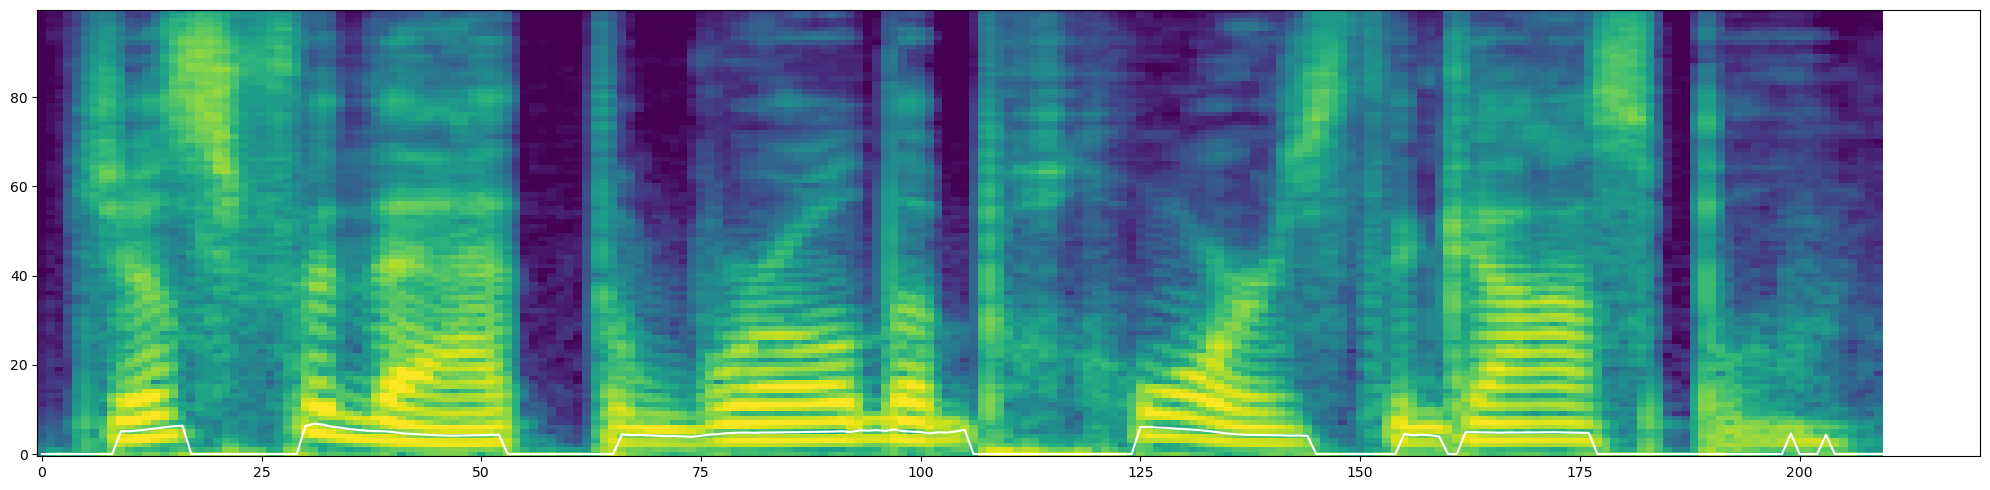

In [5]:
# Load audio
index = 305
waveform = load_mono_audio(files[index], sample_rate = config.audio.sample_rate)
prompt = model.load_prompt(files[index], tg[index])
prompt_no_styles = (prompt[0], (prompt[1][0], None))
print("Source audio")
plot_debug(waveform)

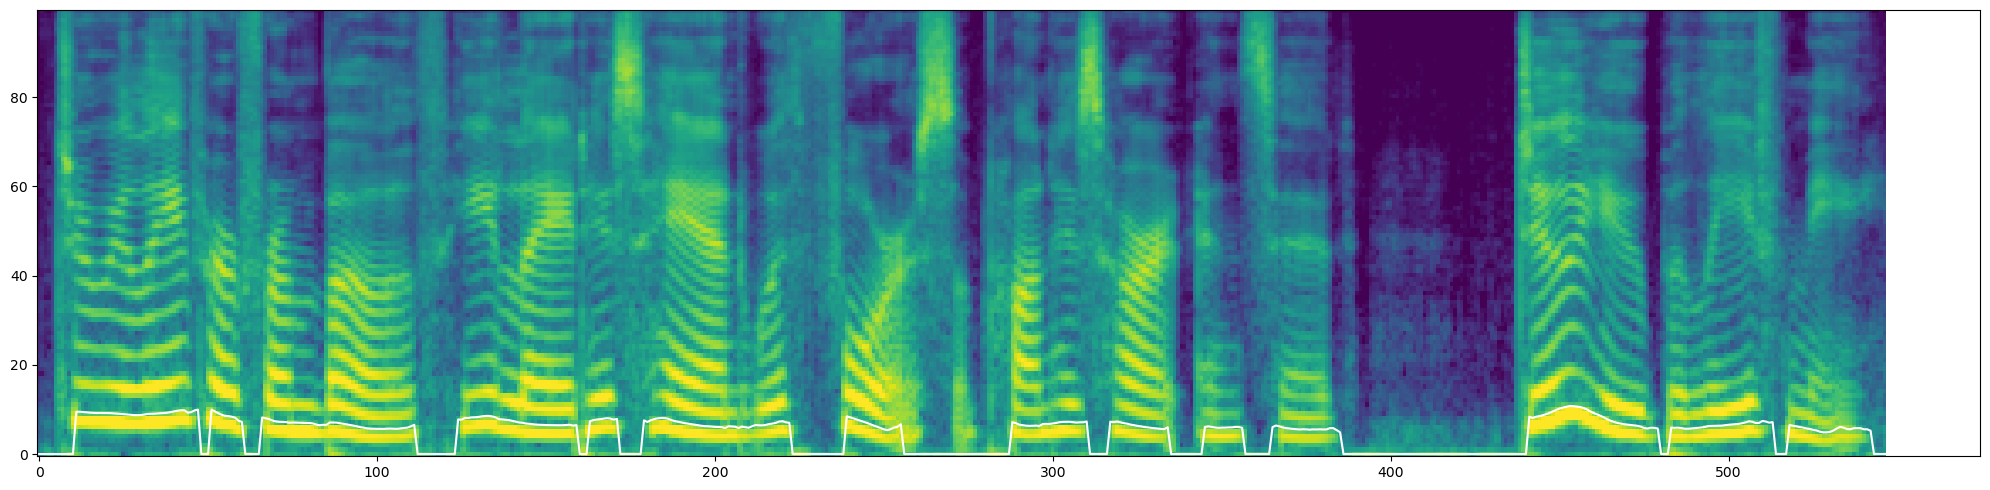

In [6]:
cond_index = 2107
cond_waveform = load_mono_audio(files[cond_index], sample_rate = config.audio.sample_rate)
conditioning = model.load_prompt(files[cond_index], tg[cond_index])
plot_debug(cond_waveform)

# Synthesize voice from phonemes
This synthesizes random voice from existing phonemes (taken from another file)

Source of phonemes


Synthesized


Synthesized w/o condition


Synthesized w/o condition and style tokens


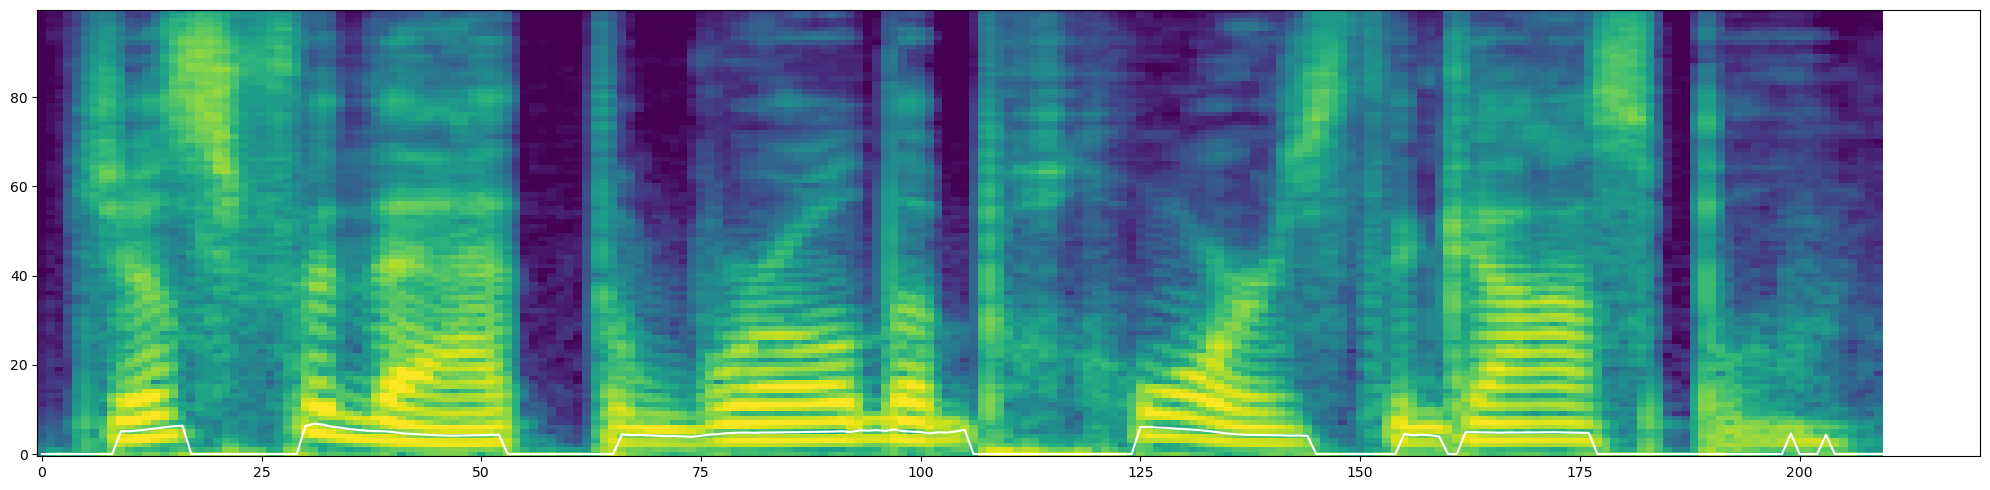

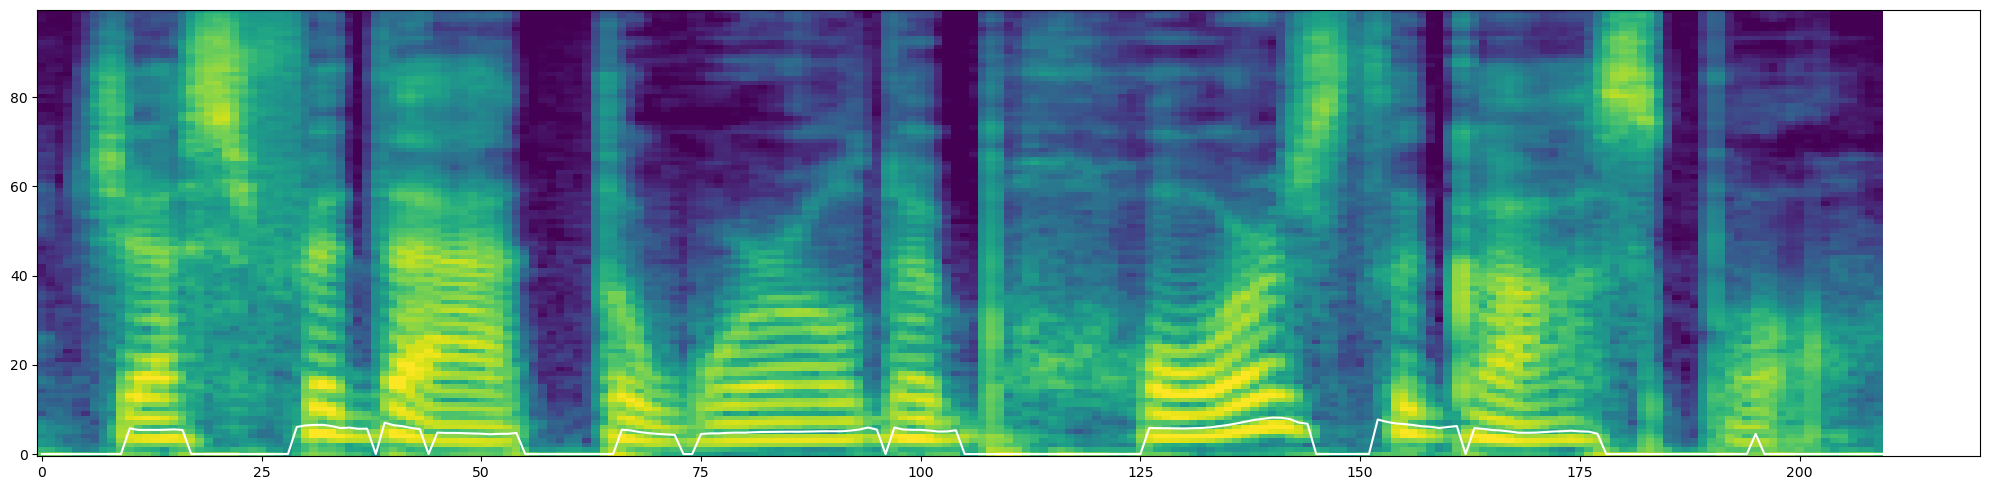

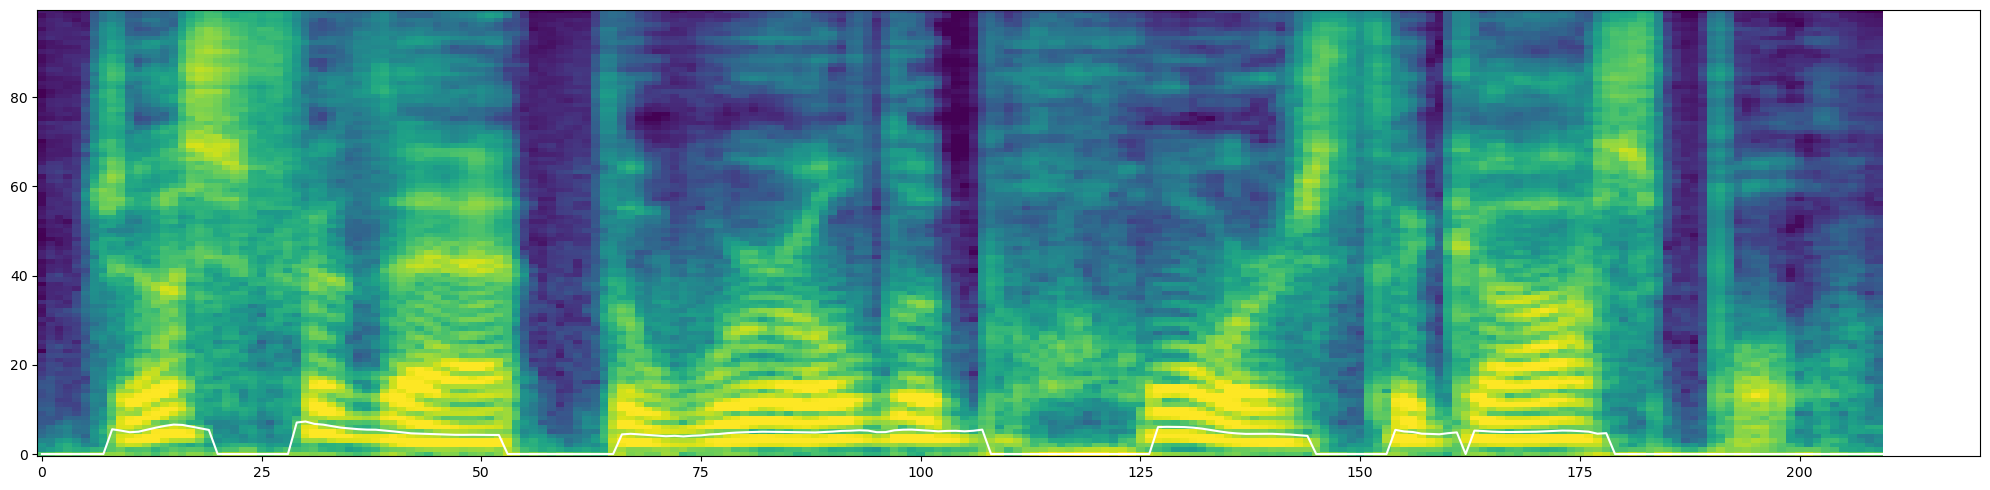

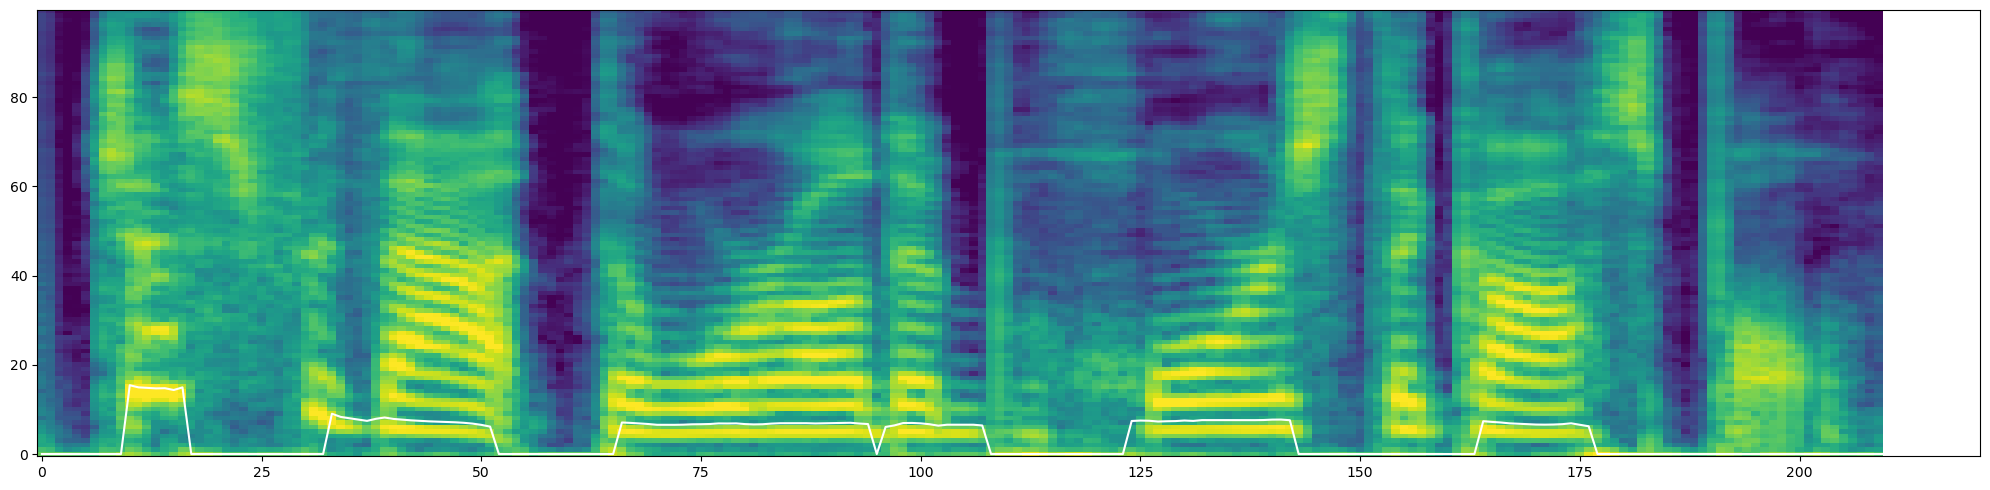

In [10]:
steps = 32
synthesized = model.synthesize(prompt[1], condition = conditioning, steps = steps)
synthesized_no_condition = model.synthesize(prompt[1], steps = steps)
synthesized_no_style = model.synthesize(prompt_no_styles[1], steps = steps)
print("Source of phonemes")
plot_debug(waveform)
print("Synthesized")
plot_debug(synthesized)
print("Synthesized w/o condition")
plot_debug(synthesized_no_condition)
print("Synthesized w/o condition and style tokens")
plot_debug(synthesized_no_style)

### Audio infill
Cut part of the audio and re-generate segment

46 187 210
Source


Restored segment with tokens provided


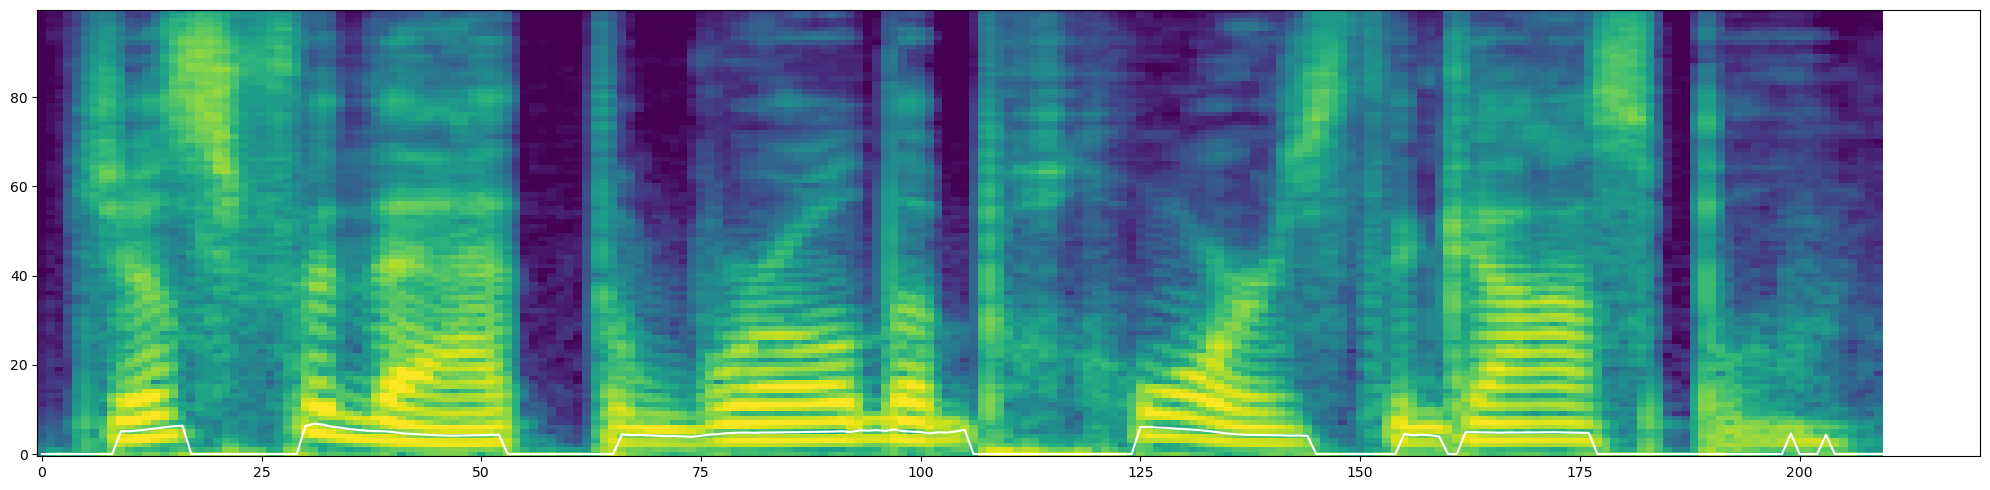

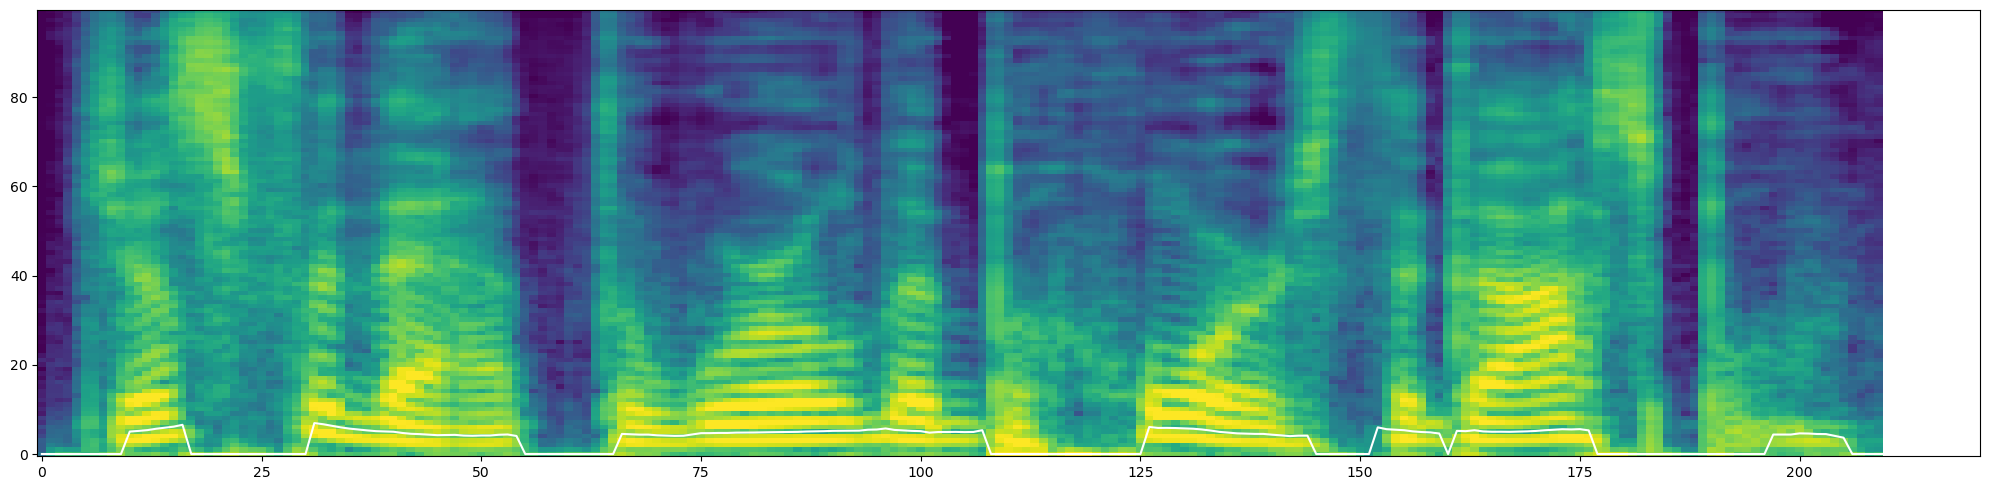

In [8]:
restored = model.restore_segment(prompt, (0.5, 2))
print("Source")
plot_debug(waveform)
print("Restored segment with tokens provided")
plot_debug(restored)

### Variativity

In [ ]:
for i in [306, 307, 1308, 1309]:

    # Load
    _waveform = load_mono_audio(files[i], sample_rate = config.audio.sample_rate)
    _style = torch.load(styles[i])
    _spec = do_spectogram(_waveform)
    _spec = _spec.to(device)
    _tokens, _, _token_styles = extract_tokens(tg[i], _style, _spec)
    _tokens = _tokens.to(device)
    _token_styles = _token_styles.to(device)
    _spec = _spec[:, :len(_tokens)]

    # Create
    _sample, _ = conditioned_tts(_tokens, _token_styles)
    _resynth = do_vocoder(_sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

    # Output
    print(f"Audio #{i}")
    display(Audio(data=_waveform, rate=config.audio.sample_rate))
    plot_debug(_resynth, _sample.transpose(1,0))

In [ ]:
type("") is str